In [85]:
chrom = '22'
family_sizes = [3, 4, 5]
phase_dir = '../phased'
data_dir = '../split_gen_miss'

In [86]:
import numpy as np

# Pull chrom length from cytogenetic coordinates
chrom_length = 0
xticks, xticklabels = [], []
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
            chrom_length = max(chrom_length, int(pieces[1]), int(pieces[2]))
print('Chrom length', chrom_length)

Chrom length 51304566


In [87]:
from collections import Counter

# sample_ids
families = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf:
        next(famf) # skip header
        for line in famf:
            pieces = line.strip().split('\t')
            families.add(pieces[0])
            
family_to_index = dict([(x, i) for i, x in enumerate(families)])
m = 4*len(family_to_index)
print('m', m)

m 3240


In [88]:
from scipy import sparse
from os import listdir

clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 

# use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])

n = len(pos_to_index)
print('n', n)

n 1003938


In [89]:
from collections import defaultdict

# load deletions
deletions = np.zeros((m, n), dtype=np.int8)-1

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
    open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
        next(famf) # skip header
        next(phasef) # skip header
        
        fam_pieces = (None,)
        
        for line in phasef:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            state = list(map(int, pieces[1:(1+(j*2))]))
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            
            # make sure we're on the right family
            while family_key != fam_pieces[0]:
                fam_pieces = next(famf).strip().split('\t')
                fam_individuals = fam_pieces[1:(1+j)]
                
            if family_key in family_to_index:
                deletions[4*family_to_index[family_key], start_index:(end_index+1)] = state[0]
                deletions[(4*family_to_index[family_key])+1, start_index:(end_index+1)] = state[1]
                deletions[(4*family_to_index[family_key])+2, start_index:(end_index+1)] = state[2]
                deletions[(4*family_to_index[family_key])+3, start_index:(end_index+1)] = state[3]

In [97]:
deletions[deletions[:, 0]==1, 0] = -1
deletions[deletions[:, -1]==1, -1] = -1
del_starts = np.where((deletions[:, :-1] != 1) & (deletions[:, 1:] == 1))
del_ends = np.where((deletions[:, :-1] == 1) & (deletions[:, 1:] != 1))
del_lengths = snp_positions[del_ends[1]]-snp_positions[del_starts[1]+1]+1

opt_del_starts = []
opt_del_ends = []

for ind_index, start, ind_index2, end in zip(del_starts[0], del_starts[1], del_ends[0], del_ends[1]):
    if ind_index == ind_index2:
        for i in range(start+1):
            if deletions[ind_index, start-i] == 0:
                break
        opt_del_starts.append(start-i+1)
        
        for i in range(1, n-end):
            if deletions[ind_index, end+i] == 0:
                break
        opt_del_ends.append(end+i-1)
    else:
        print('Error', in_index, ind_index2, start, end)
        
opt_del_lengths = snp_positions[opt_del_ends]-snp_positions[opt_del_starts]+1


min length 21 max length 960035 num 136310 median 2452.0
min length 24 max length 29526195 num 136310 median 3835.0


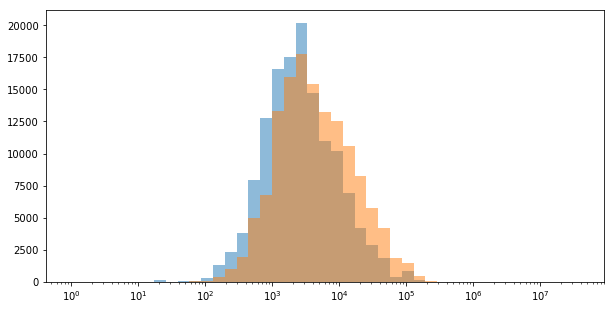

In [98]:
import math

plt.figure(figsize=(10, 5))
base = 1.5
max_length = max(opt_del_lengths) 
min_length = min(del_lengths) 
print('min length', min(del_lengths) , 'max length', max(del_lengths) , 'num', len(del_lengths), 'median', np.median(del_lengths))
print('min length', min(opt_del_lengths) , 'max length', max(opt_del_lengths) , 'num', len(opt_del_lengths), 'median', np.median(opt_del_lengths))

plt.hist(del_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist(opt_del_lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

Percent 1 0.4323013718729367
Percent 1 0.4222140708678747
min length 1 max length 9389781 num 136310 median 46.0
min length 1 max length 29517832 num 136310 median 53.0


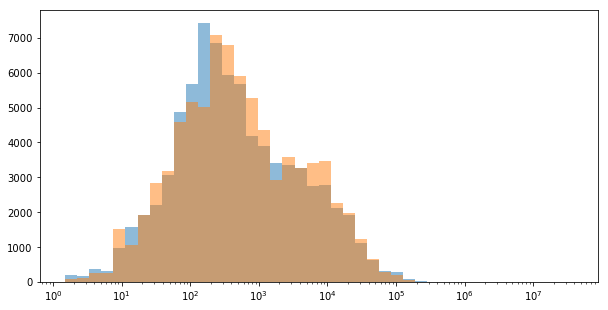

In [100]:
plt.figure(figsize=(10, 5))
base = 1.5

start_unknown = snp_positions[del_starts[1]+1]-snp_positions[opt_del_starts]+1
end_unknown = snp_positions[opt_del_ends]-snp_positions[del_ends[1]]+1

print('Percent 1', len([x for x in start_unknown if x == 1])/len(start_unknown))
print('Percent 1', len([x for x in end_unknown if x == 1])/len(end_unknown))

max_length = max(max(start_unknown), max(end_unknown))
min_length = min(min(start_unknown), min(end_unknown))
print('min length', min(start_unknown) , 'max length', max(start_unknown) , 'num', len(start_unknown), 'median', np.median(start_unknown))
print('min length', min(end_unknown) , 'max length', max(end_unknown) , 'num', len(end_unknown), 'median', np.median(end_unknown))

plt.hist(start_unknown, bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.hist(end_unknown, bins=[pow(base, i) for i in range(1, math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()